In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
!pip install rarfile
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image




url = 'https://drive.google.com/uc?id=1tKIQZr4UUV-Ybz6rRQNhnqHDi1yQ2Ib5'
output_rar = '/content/SDR.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')
# Path to the extracted dataset folder
dataset_folder = '/content/SDR'

Downloading...
From (original): https://drive.google.com/uc?id=1tKIQZr4UUV-Ybz6rRQNhnqHDi1yQ2Ib5
From (redirected): https://drive.google.com/uc?id=1tKIQZr4UUV-Ybz6rRQNhnqHDi1yQ2Ib5&confirm=t&uuid=2cc055a2-d7ab-4468-943b-4a539f744b84
To: /content/SDR.rar
100%|██████████| 221M/221M [00:01<00:00, 128MB/s]


In [4]:
import os
import shutil
import numpy as np

# Define paths
base_dir = "/content/Augmented"
train_dir = "/content/SDS/Train"
val_dir = "/content/SDS/Validation"

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define class names
class_names = ['Class0', 'Class1', 'Class2', 'Class3', 'Class4']

# Split data (80% Train, 20% Validation)
for class_name in class_names:
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)
    np.random.shuffle(images)

    split_idx = int(len(images) * 0.8)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Create subdirectories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move images
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Data split completed: 80% Train, 20% Validation.")


Data split completed: 80% Train, 20% Validation.


# ResNet-18 using SWISH

In [5]:
#ResNet-18 A refined ResNet18 architecture with swish SERENA2023
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Flatten, Dense

# Define the Swish activation function
def swish(x):
    return x * tf.keras.backend.sigmoid(x)
# Define the CNN architecture
input_shape = (224, 224, 3)
num_classes = 5  # Change this to the number of classes in your problem

# Input
inputs = Input(shape=input_shape)

# Initial convolution layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation(swish)(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Residual blocks
num_blocks = [2, 2, 2, 2]  # Number of residual blocks in each stage

for stage in range(4):
    for block in range(num_blocks[stage]):
        # First residual block in each stage has a stride of 2
        if stage > 0 and block == 0:
            strides = (2, 2)
        else:
            strides = (1, 1)

        # Convolutional block
        y = Conv2D(64 * 2**stage, (3, 3), strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation(swish)(y)

        # Convolutional block
        y = Conv2D(64 * 2**stage, (3, 3), padding='same')(y)
        y = BatchNormalization()(y)

        # Shortcut connection
        if strides == (2, 2) or x.shape[-1] != y.shape[-1]:
            x = Conv2D(64 * 2**stage, (1, 1), strides=strides, padding='same')(x)
            x = BatchNormalization()(x)

        # Add the shortcut to the main path
        x = Add()([x, y])
        x = Activation(swish)(x)

# Global average pooling and final dense layer
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the ResNet-18 model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,193,477 (42.70 MB)

 Trainable params: 11,183,877 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

# **Fold#1** ResNet-18

Found 6400 images belonging to 5 classes.
Found 1600 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3936 - loss: 1.5031
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to /content/Split/Save/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 151ms/step - accuracy: 0.3937 - loss: 1.5022 - val_accuracy: 0.2000 - val_loss: 2.2889
Epoch 2/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4542 - loss: 1.1856
Epoch 2: val_accuracy improved from 0.20000 to 0.28688, saving model to /content/Split/Save/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 142ms/step - accuracy: 0.4542 - loss: 1.1856 - val_accuracy: 0.2869 - val_loss: 1.5642
Epoch 3/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4822 - loss: 1.1574
Epoch 3: val_accuracy improved from 0.28688 to 0.45000, saving model to /content/Split/Save/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.4822 - loss: 1.1574 - val_accuracy: 0.4500 - val_loss: 1.5519
Epoch 4/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/ste

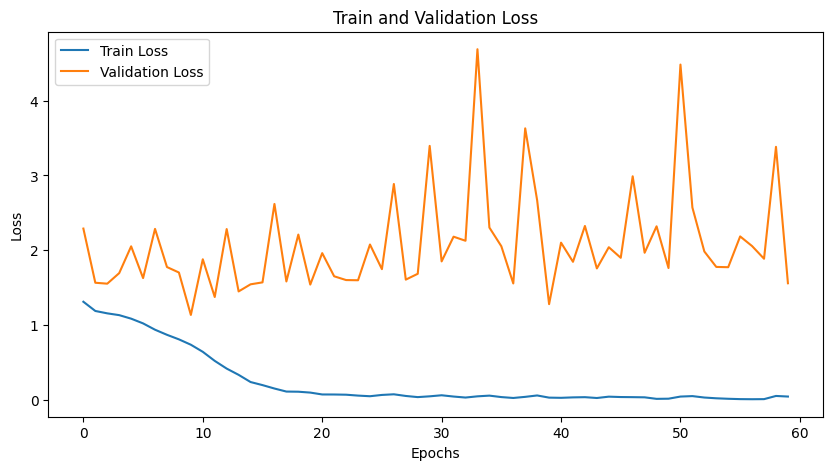

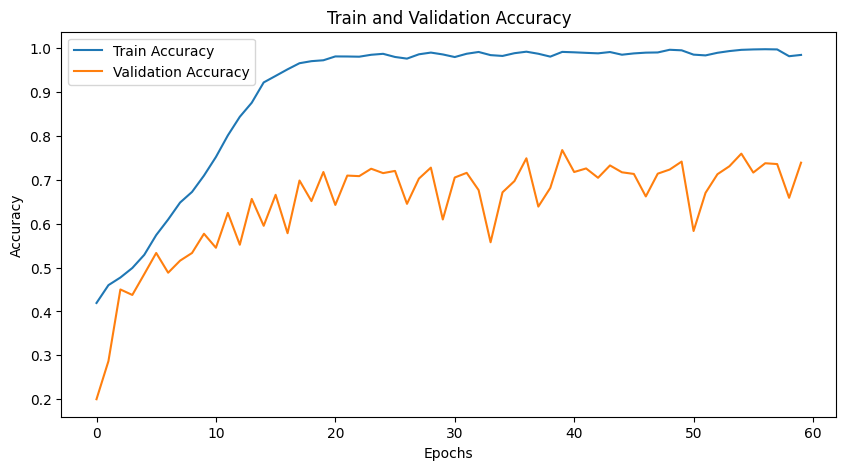

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load and preprocess the images
data_dir = '/content/SDS/Train'
class_names = ['Class0', 'Class1', 'Class2', 'Class3', 'Class4' ]
img_size = (224, 224)
batch_size = 32
epochs = 60
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the data generator for training set
train_data_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='training')

# Create the data generator for validation set
validation_data_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='validation')

# Assuming the model is already defined before compiling
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save best weights based on validation accuracy
# Define the ModelCheckpoint callback to save best weights based on validation accuracy
best_weights_path = '/content/Split/Save/best_model.keras'
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model and get the training history
history = model.fit(train_data_generator, epochs=epochs, validation_data=validation_data_generator, verbose=1, callbacks=[checkpoint])

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

In [7]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/SDS/Validation'

# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 2000 images belonging to 5 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step
Test Accuracy: 0.7845
Test Precision: 0.7833016071985259
Test Recall: 0.7845
Test F1-score: 0.7802282736369553
Confusion Matrix:
[[390   4   6   0   0]
 [ 15 343  25   4  13]
 [ 22  81 230  38  29]
 [  6  23  25 310  36]
 [  3  32  31  38 296]]
